<a href="https://colab.research.google.com/github/mddaniya1/bank_customer_support/blob/main/agentic_ai_chatbot_prototype_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective:

Create a chatbot prototype that talks to users, remembers what they say during conversation, and helps them solve problems.

## Project Requirements:

- ***Choose Your Niche:*** Pick a specific group of people or industry to help with your chatbot (e.g., students, healthcare, customer service).

- ***Make Smart Conversations:*** Make sure the chatbot answers correctly and understands what users want. Use Prompt Engineering.

- ***Add Useful Tools:*** Give the chatbot features like helping users submit complaints, giving outfit ideas, or making study plans.

- ***Short-Term Memory:*** Make the chatbot remember the current conversation to give better answers.

- ***Use Google Colab:*** Build and test your chatbot using this platform.

## Deliverables:

- A working chatbot prototype - Google Collab Link.

- A list of tools and examples of how the chatbot can help people.

# Setup

- First, install the required packages:

In [ ]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai

- Next, set your API keys:

In [ ]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "quickstart"

gemini_api_key = userdata.get('GEMINI_API_KEY')
tavily_api_key = userdata.get('TAVILY_API_KEY')

- Setting up LLM model

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)

llm.invoke("greet me")

AIMessage(content='Hello there!\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-38f05682-8532-4de8-9dcf-b742ef426c4f-0', usage_metadata={'input_tokens': 3, 'output_tokens': 4, 'total_tokens': 7, 'input_token_details': {'cache_read': 0}})

- Now, creating a chatbot for the students of computer science, which have useful tools and shot-term memory.

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


# Memory for short-term conversation
conversation_memory = {}

def remember_user_input(key, value):
    """Stores user input in conversation memory."""
    conversation_memory[key] = value


# State definition
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Initialize StateGraph
graph_builder = StateGraph(State)


# Tools

def mcb_bank_customer_support(query: str) -> str:
    """Provide responses for common banking customer support queries."""
    prompt = f"Provide a helpful response to the following bank customer support query:\n{query}"
    return llm.invoke(prompt)

def code_explainer(code_snippet: str) -> str:
    """Explain the given code snippet in simple terms."""
    prompt = f"Explain the following code in simple terms:\n\n{code_snippet}"
    return llm.invoke(prompt)

def generate_cheat_sheet(topic: str) -> str:
    """Generate a cheat sheet for a given topic."""
    prompt = f"Create a detailed cheat sheet for the topic: {topic}. Include key points and examples."
    return llm.invoke(prompt)

def smart_todo_list(tasks: str) -> str:
    """Organize the tasks into a smart to-do list."""
    prompt = f"Organize the following tasks into a prioritized to-do list with deadlines:\n{tasks}"
    return llm.invoke(prompt)

# Combine all tools
tools = [code_explainer, generate_cheat_sheet, smart_todo_list]

# Add MCB Bank Customer Support tool
tools.append(mcb_bank_customer_support)


# Initialize LLM
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)
llm_with_tools = llm.bind_tools(tools)


# System message
sys_msg = SystemMessage(content="You are a helpful assistant for MCB bank customer support. Your role is to provide clear and accurate answers to common customer inquiries related to banking services, such as account details, transactions, loans, and troubleshooting issues.")


# Node
def assistant(state: MessagesState) -> MessagesState:
    # Extract the last user message
    last_message = state["messages"][-1] if state["messages"] else None

    # Check if the last message is a HumanMessage
    if isinstance(last_message, HumanMessage):
        # Remember the user input
        remember_user_input("last_user_input", last_message.content)

    # Prepare the response with memory context
    memory_context = ""
    if "last_user_input" in conversation_memory:
        memory_context = f"Previously, you mentioned: {conversation_memory['last_user_input']}\n"

    # Invoke the LLM with the system message, memory context, and current messages
    response = llm_with_tools.invoke([sys_msg, memory_context] + state["messages"])

    return {"messages": [response]}

# Example Test
if __name__ == "__main__":
    # Sample user query
    user_query = "What is the status of my loan application?"

    # Initialize messages state
    state = {
        "messages": [
            HumanMessage(content=user_query)
        ]
    }

    # Get response from the assistant
    response = assistant(state)
    print(response["messages"][0])  # Print the assistant's response


content="To check the status of your loan application, I'll need some identifying information.  Could you please provide your full name and National Identification Card number (CNIC)?  This will help me securely access your application details and provide you with an update.\n" additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run-e9b155e5-5478-4d87-8167-937f918b3fe2-0' usage_metadata={'input_tokens': 250, 'output_tokens': 52, 'total_tokens': 302, 'input_token_details': {'cache_read': 0}}


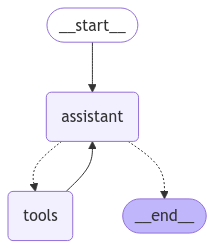

In [ ]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph

# Graph
builder: StateGraph = StateGraph(MessagesState)

# Define nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph: CompiledStateGraph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

- **Explains code snippets in simple terms, making it easier for students to understand complex code.**

In [ ]:
messages = [HumanMessage(content="I need help with my MCB bank account balance. Can you check it for me?")]
messages = react_graph.invoke({"messages": messages})

In [ ]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

I need help with my MCB bank account balance. Can you check it for me?
================================== Ai Message ==================================

I cannot directly access your private financial information, including your MCB bank account balance, due to security and privacy restrictions.  To check your account balance, I recommend using one of the following secure methods:

* **MCB Bank Mobile App:** Download the official MCB Bank mobile app and log in to view your balance.
* **MCB Bank Online Banking:** Access your account through the MCB Bank online banking portal.
* **MCB Bank ATM:** Visit the nearest MCB Bank ATM and check your balance using your debit card.
* **Contact MCB Bank Customer Service:** Call their customer service hotline for assistance.  They will be able to verify your identity and provide your balance.


Please choose the method most convenient for you. Remember to protect your 

In [ ]:
print(conversation_memory)

{'last_user_input': 'I need help with my MCB bank account balance. Can you check it for me?'}


- **Creates concise cheat sheets for various topics in computer science, summarizing key concepts and examples.**

In [ ]:
messages = [HumanMessage(content= "A customer has lost their ATM card. Can you guide them through the process of blocking the card and applying for a replacement?"
)]
messages = react_graph.invoke({"messages": messages})

In [ ]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

A customer has lost their ATM card. Can you guide them through the process of blocking the card and applying for a replacement?
================================== Ai Message ==================================

Here's how a customer can block their lost ATM card and apply for a replacement:

**1. Immediately Block the Card:**

* **Call MCB Bank's 24/7 Hotline:**  The first and most crucial step is to call MCB Bank's customer service hotline immediately.  They will provide you with instructions to block your card to prevent unauthorized transactions.  Have your account details ready.

* **Use MCB Bank's Mobile App (if available):** Many banks offer mobile apps where you can temporarily block your card yourself. Check your app for this feature.

**2. Report the Loss:**

* **Formal Report:** After blocking the card, file a formal report of the loss with the bank. This may involve completing a form either onli

In [ ]:
print(conversation_memory)

{'last_user_input': 'A customer has lost their ATM card. Can you guide them through the process of blocking the card and applying for a replacement?'}


- **Organizes tasks into a prioritized to-do list, helping students manage their assignments and projects effectively.**

In [ ]:
messages = [HumanMessage(content="Can you assist the customer in setting up MCB's mobile banking app and explain how to use it for everyday transactions?")]
messages = react_graph.invoke({"messages": messages})

In [ ]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Can you assist the customer in setting up MCB's mobile banking app and explain how to use it for everyday transactions?
================================== Ai Message ==================================

Sure, I can help with that.  To assist a customer in setting up MCB's mobile banking app and explain its use for everyday transactions, I need more information about the specific MCB mobile banking app.  Different banks have different apps with varying features and setup processes.

However, I can provide a general guide that applies to most mobile banking apps.  This guide will cover the typical steps and functionalities.  Remember that specific details might differ based on the MCB app version.

**Setting up the MCB Mobile Banking App:**

1. **Download and Installation:** The customer should start by downloading the official MCB mobile banking app from their device's app store (Google Play Store for Andro

In [ ]:
print(conversation_memory)

{'last_user_input': "Can you assist the customer in setting up MCB's mobile banking app and explain how to use it for everyday transactions?"}


In [ ]:
messages = [
    HumanMessage(content="I apologize for the previous error. I am still learning to access and process information. Please let me know if you're experiencing issues with MCB Bank services. For example, are you having trouble with online banking, account access, transactions, or something else? Please provide details such as error messages or actions that led to the issue.")
]

messages = llm_with_tools.invoke(messages)

In [ ]:
messages.pretty_print()

================================== Ai Message ==================================

I do not have personal experiences or access to real-time information, including the status of MCB Bank services.  I am a language model and cannot experience issues like a human user would.  To get help with MCB Bank services, you should contact their customer support directly.


In [ ]:
print(conversation_memory)

{'last_user_input': "Can you assist the customer in setting up MCB's mobile banking app and explain how to use it for everyday transactions?"}


In [ ]:
def stream_graph_updates(user_input: str):
    for event in react_graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: To answer your query, I need access to your account information.  However, I cannot directly access private customer data due to security and privacy restrictions.  To check your account balance, please use one of the following methods:

* **MCB Bank Mobile App:** Log in to the MCB Bank mobile app and view your account balance.
* **MCB Bank Online Banking:** Log in to your online banking account at the MCB Bank website and check your balance.
* **Visit a Branch:** Visit your nearest MCB Bank branch and request your account balance from a bank representative.
* **Call Customer Service:** Call MCB Bank's customer service number and provide necessary security information to verify your identity and obtain your balance.

Please note that you will need your login credentials (username and password) for the app and online banking options.  If you have forgotten your credentials, you'll find instructions for password recovery on the MCB Bank website or app.

Assistant: To answer yo